This notebook is to train the semantic module for testing

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    '''
    self attention mechanism for bilstm outputs
    
    '''
    
    
    
    def __init__(self, embed_size):
        super().__init__()
        
        
        self.embed_size = embed_size
        #define linear transformations for Q,K,V
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size,embed_size)
        self.value = nn.Linear(embed_size,embed_size)
        
        self.scale = torch.sqrt(torch.FloatTensor([embed_size]))
        
    def forward(self, x):
        '''
        here x is the ouput from the lstm layer 
        which is in the form of (batch_size, time_Steps, units) when return_Sewunces are true
        batch_size - number of sequences processed at once
        time_Steps - number of embeddings in each sequence like how many embedding vectors 
        units - number of lstm units where each unit represents one dimension of the hidden state at each time step
        (batch_size, time_steps, embedding_dim) -> input shape
                       ||
                       ||
                 -- LSTM layer --
                       ||
                       ||
          (batch_size, tim_steps, units)  -> output shape
          
        we need to generate the Q,K,V matrices
         Returns:
            attended_output: (batch, hidden_size) weighted representation
            attention_weights: (batch, seq_len) importance scores
        '''
        
        
        
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        # calculating attetnion_Scores Q x K^T
        
        attention_scores = torch.matmul(Q, K.transpose(-2,-1))/ (self.scale.to(x.device)) 

        # (batch_size, seq_len, embed_dim) K.transpose(-2, -1) → shape (batch_size, embed_dim, seq_len)
        #Without scaling, dot products can be large, making softmax very peaky and gradients unstable.
        #.to(x.device) ensures self.scale is on the same device as the input (CPU or GPU), so no device mismatch occurs.

        #applying softmax function
        
        attention_weights = F.softmax(attention_scores.mean(dim = 1), dim = -1)
        
        # Apply attention to values
        attention_weights_expanded = attention_weights.unsqueeze(1)  # (batch, 1, seq_len)
        attended_output = torch.matmul(attention_weights_expanded, V).squeeze(1)  # (batch, hidden_size)
        
        return attended_output, attention_weights
        
        

In [13]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 

class SemanticModule(nn.Module):
    '''
    Architecture goes like this
    - conv block 1 : conv1d 16 filters -> relu -> batch norm -> max pool
    - conv block 2 : conv1d 32 filters -> relu -> batch norm -> max pool
    - bi-lstm : 32 hidden units
    - output : 100 dimensional features
    '''
    def __init__(self, embedding_dim, output_features = 100):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels = 1, # single channel input
                               out_channels = 16, # number of  filters
                               kernel_size = 5, #kernel size need to experiment with 2,4,5,7
                               padding = 2 
                               # padding  = 0 valid convolution no padding output shrinks
                               # padding = (kernel_size -1)/2 -> to keep output sequence length as input 
                               # here stride = 1
                               )
        
        self.batch_norm1 = nn.BatchNorm1d(16) # normalizes the output layer , basically keeps activations(features) within stable range during training
        
        self.pool1 = nn.MaxPool1d(kernel_size = 3) # generally if kernel size = 3 then stride is also 3
        
        self.conv2 = nn.Conv1d(
            in_channels = 16, #from first block number of output_features
            out_channels = 32,
            kernel_size = 5,
            padding = 2
            )
        
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size = 3)
        
        # birectional lstm
        
        self.lstm = nn.LSTM(
            input_size = 32, # from conv2 ouput channels
            hidden_size = 32, # 32 hidden_units
            num_layers =1,
            batch_first = True,
            bidirectional = True # bilstm outputs 64 features
        )
        
        #ading attention layer for explanability
        self.attention = AttentionLayer(embed_size = 64)
        
        self.fc = nn.Linear(64, output_features)
        
        self.attention_weights = None
        
    def forward(self,x):
        
        
        batch_size = x.size(0)
        
        x = x.unsqueeze(1) #reshape for conv1d
        
        # 1st convoultional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        # 2nd convoultional layer 
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x =x.transpose(1,2) #(batch_size,seq_len,32)
        # lstm : (batch,seq_len, features)
        
        lstm_out, (hidden,cell) = self.lstm(x)
        #lstm_out = (batch, seq_len, 64)
        
        # APPLY ATTENTION (learns which parts of sequence are important)
        attended_output, attention_weights = self.attention(lstm_out)
        # attended_output: (batch, 64)
        # attention_weights: (batch, seq_len) - shows important code positions
        
        # Store for explainability
        self.attention_weights = attention_weights
        
        # Project to output dimension
        features = self.fc(attended_output)  # (batch, 100)
        
        return features, attention_weights
          

        
        

In [23]:
import pickle
path = r"D:\0_final_project\DeepEnsemble\dataset-source\embedding-dataset\code2vec\GodClass_code2vec_embeddings.pkl"

with open(path, 'rb') as file:
    data = pickle.load(file)

print(data.columns)


Index(['embedding', 'sample_id', 'label'], dtype='object')


In [15]:
embeddings = data['embedding']

# converting to pytorch tensor

if not isinstance(embeddings,torch.Tensor):
    embeddings = torch.FloatTensor(embeddings)

print(embeddings.shape) # [2086,384] 208c vector and each vector has 384 dimension

# 3. Initialize the model
embedding_dim = embeddings.shape[1]  # Get the embedding dimension from your data
model = SemanticModule(embedding_dim=embedding_dim, output_features=100)

torch.Size([2086, 384])


Using device: cuda
Data keys: Index(['embedding', 'sample_id', 'label'], dtype='object')
Embedding shape: (2086,)
Embeddings shape: torch.Size([2086, 384])
Sample shape: torch.Size([1, 384])
Output features shape: torch.Size([1, 100])
Attention weights shape: torch.Size([1, 42])


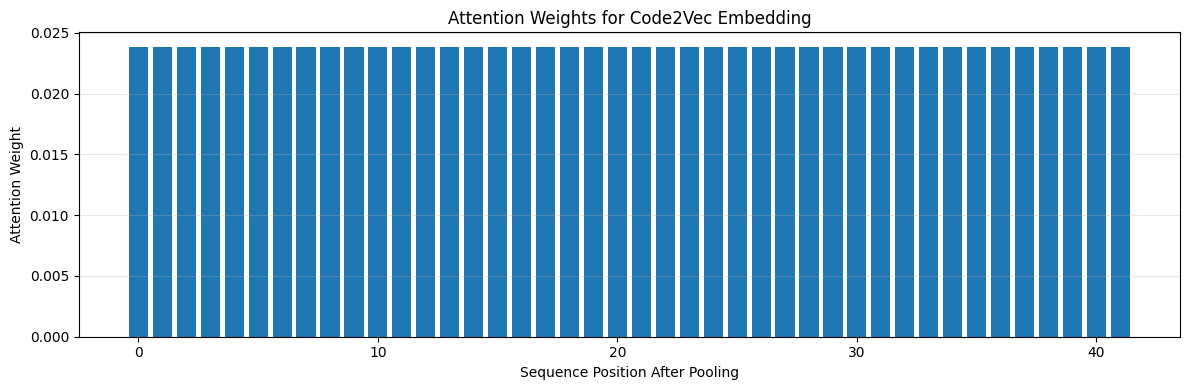


Top 5 most important sequence positions:
1. Position 0: 0.0238
2. Position 41: 0.0238
3. Position 1: 0.0238
4. Position 40: 0.0238
5. Position 8: 0.0238


In [21]:
import torch
import pickle
import matplotlib.pyplot as plt

# 1. Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Load data
path = r"D:\0_final_project\DeepEnsemble\dataset-source\embedding-dataset\code2vec\GodClass_code2vec_embeddings.pkl"
with open(path, 'rb') as file:
    data = pickle.load(file)

print(f"Data keys: {data.keys()}")
print(f"Embedding shape: {data['embedding'].shape}")

# 3. Prepare embeddings
embeddings = torch.FloatTensor(data['embedding']).to(device)  # Move to device
print(f"Embeddings shape: {embeddings.shape}")

# 4. Initialize model
embedding_dim = embeddings.shape[1]
model = SemanticModule(embedding_dim=embedding_dim, output_features=100)
model = model.to(device)  # Move model to device
model.eval()

# 5. Run inference on single sample
with torch.no_grad():
    sample = embeddings[0].unsqueeze(0)  # (1, embedding_dim)
    print(f"Sample shape: {sample.shape}")
    
    features, attention_weights = model(sample)
    
    print(f"Output features shape: {features.shape}")
    print(f"Attention weights shape: {attention_weights.shape}")
    
    # 6. Visualize attention weights
    plt.figure(figsize=(12, 4))
    attention_np = attention_weights[0].cpu().numpy()  # Move to CPU for plotting
    
    plt.bar(range(len(attention_np)), attention_np)
    plt.xlabel('Sequence Position After Pooling')
    plt.ylabel('Attention Weight')
    plt.title('Attention Weights for Code2Vec Embedding')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print top-k most important positions
    top_k = 5
    top_indices = torch.topk(attention_weights[0], k=top_k).indices.cpu().numpy()
    top_values = torch.topk(attention_weights[0], k=top_k).values.cpu().numpy()
    
    print(f"\nTop {top_k} most important sequence positions:")
    for idx, (pos, weight) in enumerate(zip(top_indices, top_values), 1):
        print(f"{idx}. Position {pos}: {weight:.4f}")

Columns: Index(['embedding', 'sample_id', 'label'], dtype='object')
Data shape: (2086, 3)

First few rows:
                                           embedding sample_id  label
0  [-0.2946510021363637, -0.04262610020454544, -0...   5786929      1
1  [-0.1240538922222222, 0.1863610448888889, 0.35...   5828468      1
2  [0.011415069684210535, -0.2543587920526315, 0....   5884892      1
3  [-0.1328723484285714, -0.4068429557142858, 0.1...   5938889      1
4  [-0.45699070583333334, -0.33904219875, -0.0641...   6079026      1

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   embedding  2086 non-null   object
 1   sample_id  2086 non-null   object
 2   label      2086 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.0+ KB
None

Label distribution:
label
0    1858
1     228
Name: count, dtype: int64

Sample embedding shape: (384,)

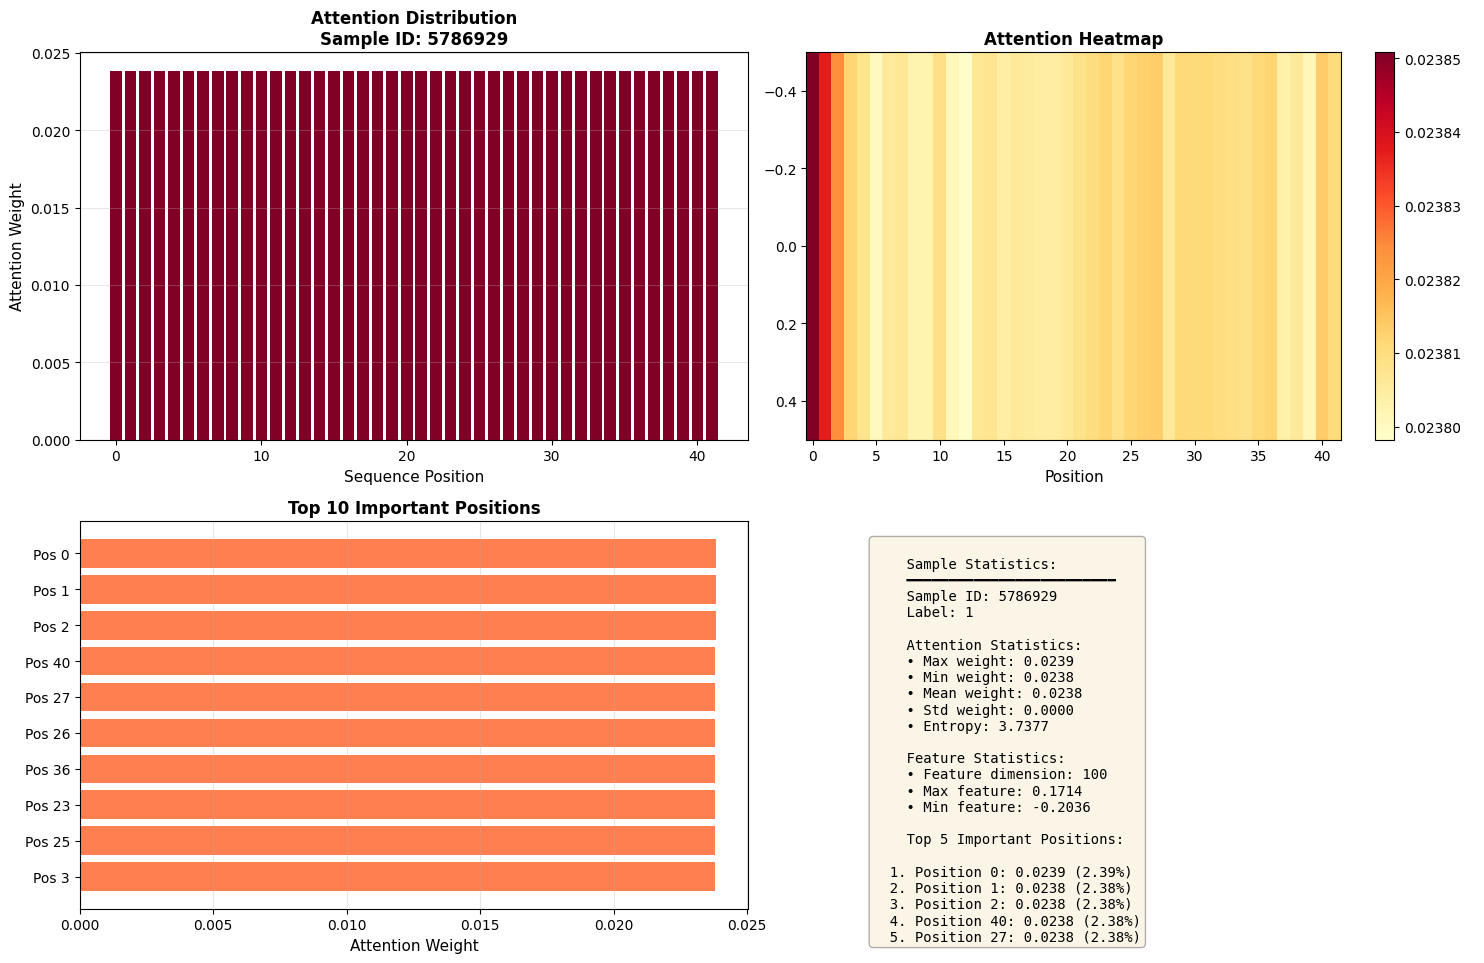


ANALYSIS SUMMARY
Sample ID: 5786929
Label: 1

Top 5 Important Positions:
  1. Position 0: 0.0239 (2.39%)
  2. Position 1: 0.0238 (2.38%)
  3. Position 2: 0.0238 (2.38%)
  4. Position 40: 0.0238 (2.38%)
  5. Position 27: 0.0238 (2.38%)


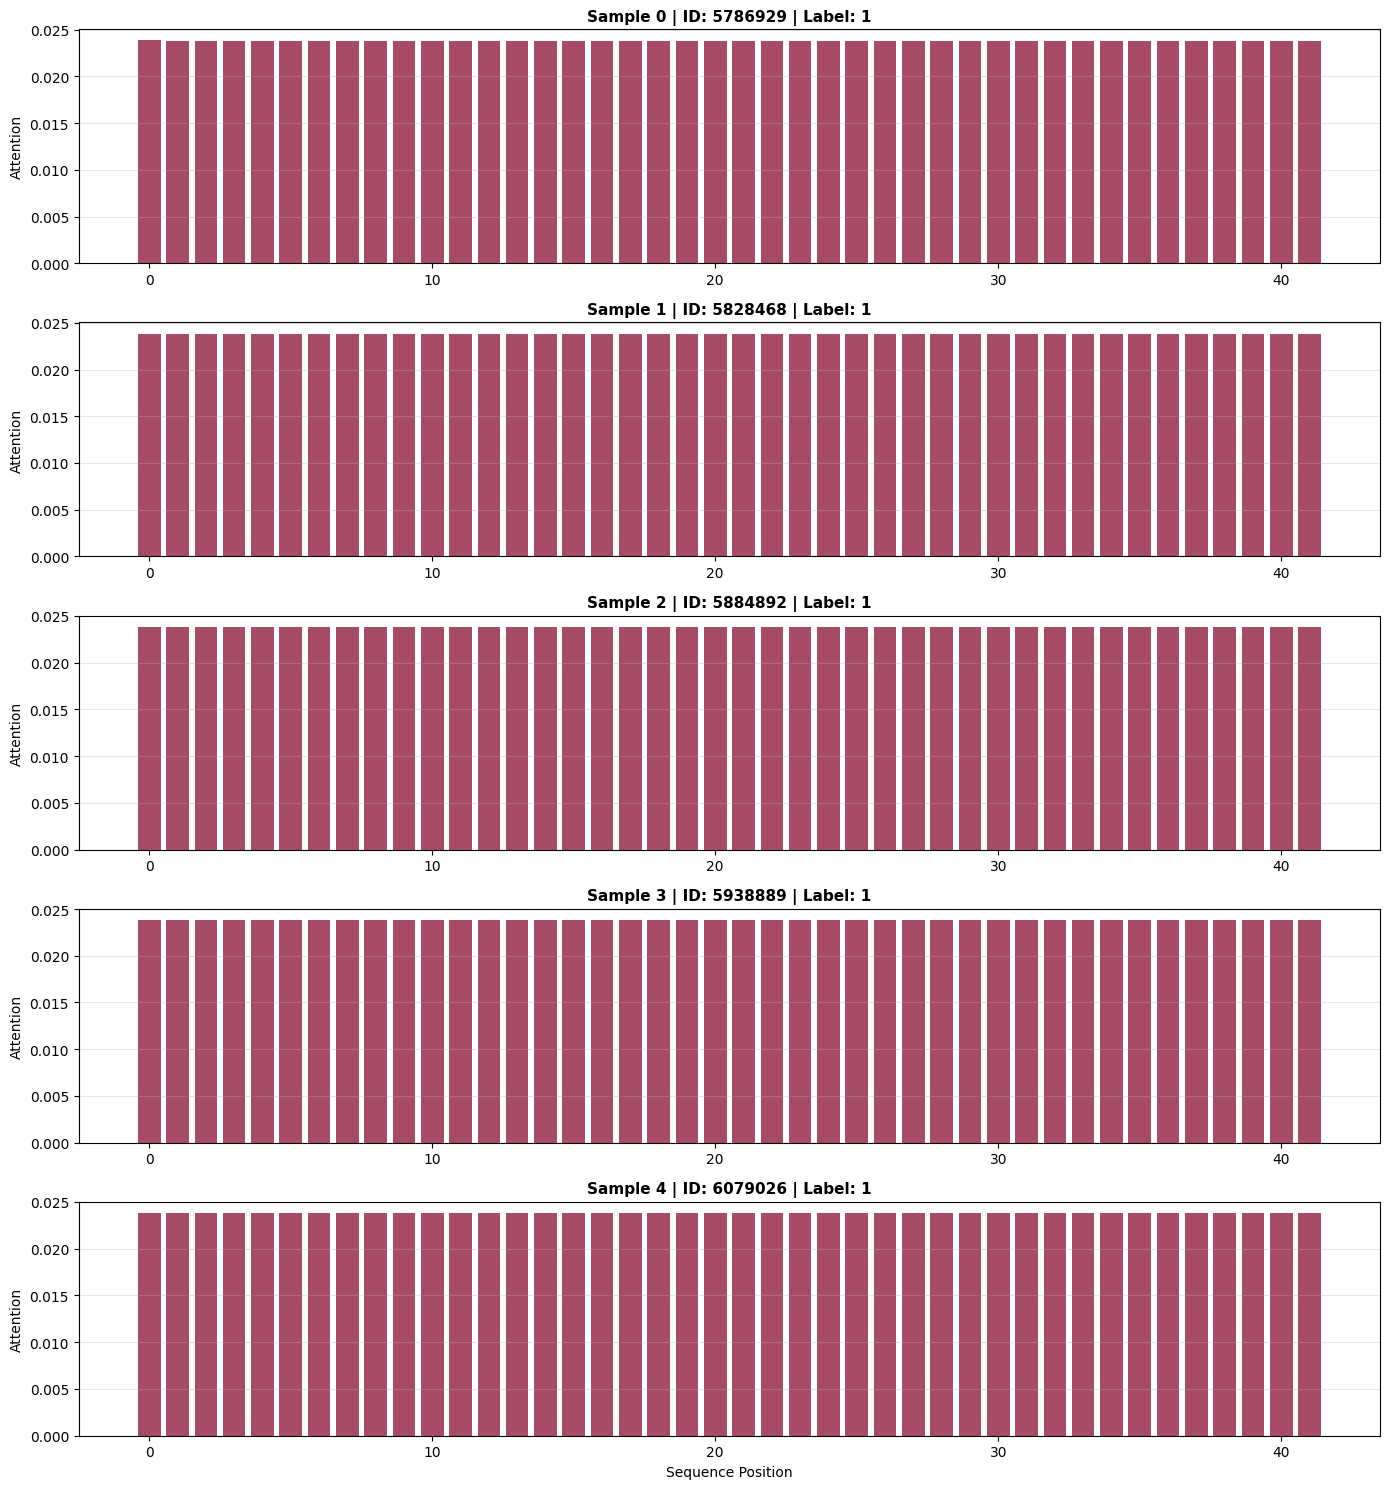

Processed 100/2086 samples
Processed 200/2086 samples
Processed 300/2086 samples
Processed 400/2086 samples
Processed 500/2086 samples
Processed 600/2086 samples
Processed 700/2086 samples
Processed 800/2086 samples
Processed 900/2086 samples
Processed 1000/2086 samples
Processed 1100/2086 samples
Processed 1200/2086 samples
Processed 1300/2086 samples
Processed 1400/2086 samples
Processed 1500/2086 samples
Processed 1600/2086 samples
Processed 1700/2086 samples
Processed 1800/2086 samples
Processed 1900/2086 samples
Processed 2000/2086 samples

Saved results with 2086 samples

Results preview:
  sample_id  label  max_attention  mean_attention  top_1_pos  top_1_weight
0   5786929      1       0.023851         0.02381          0      0.023851
1   5828468      1       0.023846         0.02381          0      0.023846
2   5884892      1       0.023847         0.02381          0      0.023847
3   5938889      1       0.023856         0.02381          0      0.023856
4   6079026      1     

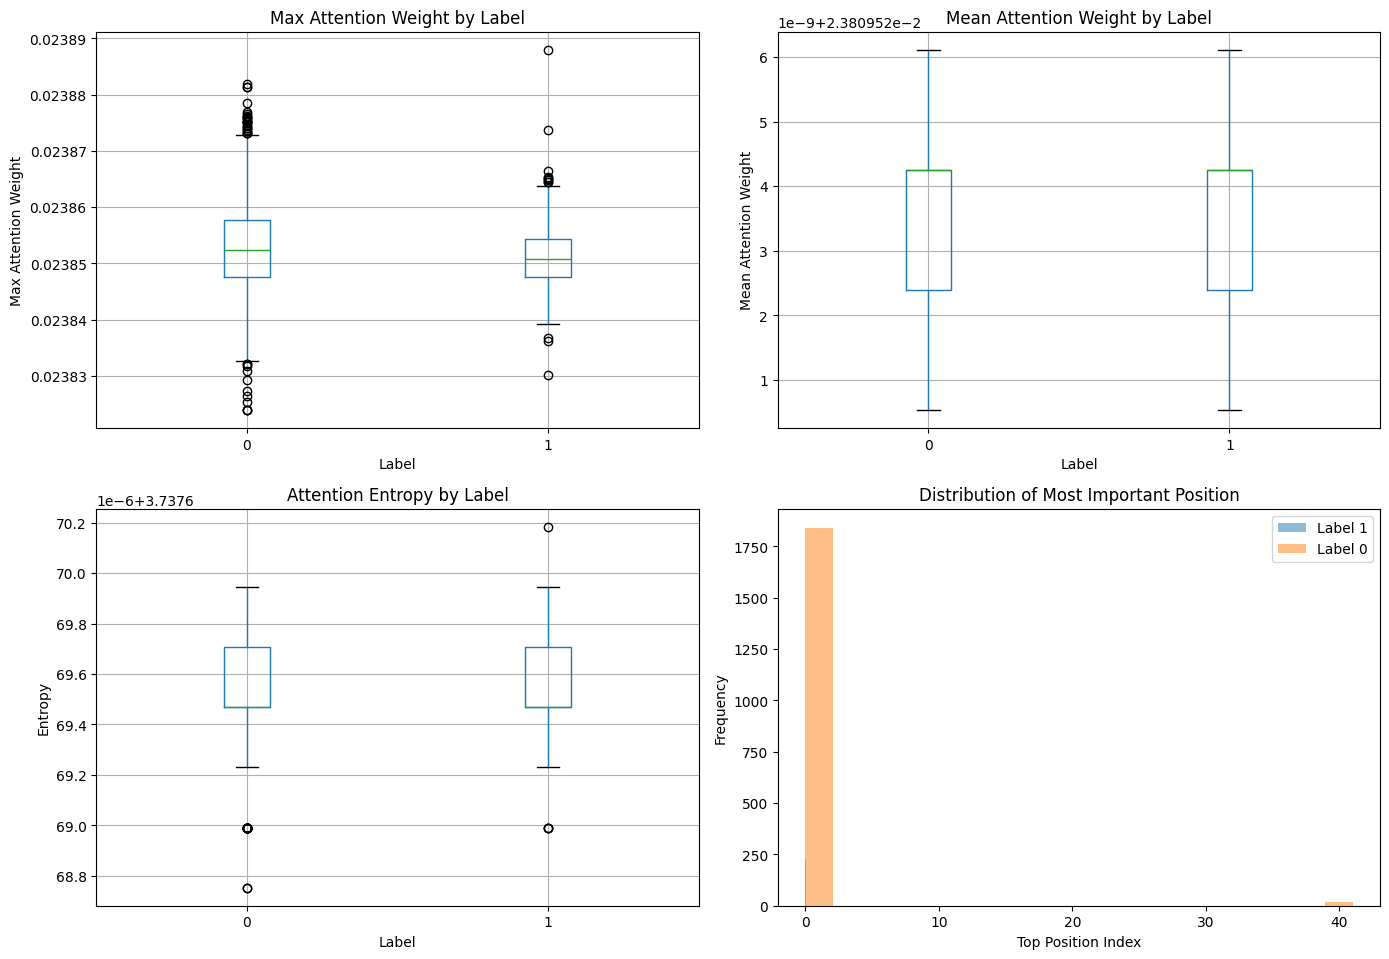


ATTENTION STATISTICS BY LABEL
      max_attention                                                    \
              count      mean       std       min       25%       50%   
label                                                                   
0            1858.0  0.023853  0.000008  0.023824  0.023848  0.023852   
1             228.0  0.023851  0.000007  0.023830  0.023848  0.023851   

                          mean_attention           ...                    \
            75%       max          count     mean  ...      75%      max   
label                                              ...                     
0      0.023858  0.023882         1858.0  0.02381  ...  0.02381  0.02381   
1      0.023854  0.023888          228.0  0.02381  ...  0.02381  0.02381   

      attention_entropy                                                       \
                  count     mean           std       min       25%       50%   
label                                                         